# Image Classification
Classify Images and wether or not they have pizza or steak in the photo.  
This data will be sourced from the [Food-101 dataset](https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/), particularly a subdivision of the images that only include  pizzas and steaks.  

## Notebook Goals
- use a pre-built set of images from the web
- build & experiment with machine-learning models
- compare binary-classification against CNN
- Address Over-fitting by utilizing
  - **`MaxPool` layers** to reduce the number of "features" that the model is dealing with
  - **data augmentation** to train the model with images that are "imperfect" to mimic real-world imperfect photos
  - shuffling training data: reduce the chances of "learning" made by the order of input data

## References
- [cnn explainer](https://poloclub.github.io/cnn-explainer/)
- [Paper on Accelerating CNN](https://arxiv.org/abs/1505.06798)
- [ImageNet](https://image-net.org/): an image db

## Pre-Built Image-recognition Models
Check out some pre-built models for image recognition:
- [ImageNet](https://www.image-net.org/): seems to be a giant well-built & well-used image-recognition model.
- [ResNet50](https://www.tensorflow.org/api_docs/python/tf/keras/applications/ResNet50)

In [1]:
import zipfile
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation
from tensorflow.keras import Sequential
import pandas as pd

## Download & Inspect Data

In [2]:
# Download zip file of pizza_steak images
fileName = 'pizza_steak.zip'
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip

# Unzip the downloaded file
zip_ref = zipfile.ZipFile(fileName, "r")
zip_ref.extractall()
zip_ref.close()

--2024-06-18 17:25:17--  https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.40.155, 142.251.40.187, 142.250.65.187, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.40.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109540975 (104M) [application/zip]
Saving to: ‘pizza_steak.zip.2’

pizza_steak.zip.2   100%[===================>] 104.47M  11.1MB/s    in 9.5s    

2024-06-18 17:25:27 (11.0 MB/s) - ‘pizza_steak.zip.2’ saved [109540975/109540975]



### Inspect The Data
The data is in a dir, `pizza_steak`.  
The dir has 2 subdirs, `test` and `train`.  
Each subdir has 2 subdirs, `pizza` and `steak`.  
Each `pizza` and `steak` dir has images included.

In [3]:
!ls pizza_steak/train/steak

1000205.jpg  1647351.jpg  2238681.jpg  2824680.jpg  3375959.jpg  417368.jpg
100135.jpg   1650002.jpg  2238802.jpg  2825100.jpg  3381560.jpg  4176.jpg
101312.jpg   165639.jpg   2254705.jpg  2826987.jpg  3382936.jpg  42125.jpg
1021458.jpg  1658186.jpg  225990.jpg   2832499.jpg  3386119.jpg  421476.jpg
1032846.jpg  1658443.jpg  2260231.jpg  2832960.jpg  3388717.jpg  421561.jpg
10380.jpg    165964.jpg   2268692.jpg  285045.jpg   3389138.jpg  438871.jpg
1049459.jpg  167069.jpg   2271133.jpg  285147.jpg   3393547.jpg  43924.jpg
1053665.jpg  1675632.jpg  227576.jpg   2855315.jpg  3393688.jpg  440188.jpg
1068516.jpg  1678108.jpg  2283057.jpg  2856066.jpg  3396589.jpg  442757.jpg
1068975.jpg  168006.jpg   2286639.jpg  2859933.jpg  339891.jpg	 443210.jpg
1081258.jpg  1682496.jpg  2287136.jpg  286219.jpg   3417789.jpg  444064.jpg
1090122.jpg  1684438.jpg  2291292.jpg  2862562.jpg  3425047.jpg  444709.jpg
1093966.jpg  168775.jpg   229323.jpg   2865730.jpg  3434983.jpg  447557.jpg
1098844.jpg  1697

In [4]:
# 
# SUMMARY OF DATA
# 

parentDir = 'pizza_steak'
# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk(parentDir):
  if(len(filenames) > 0):
      print(f"    {len(filenames)} images in '{dirpath}'.")
  else:
      print(f"DIR: '{dirpath}' has {len(dirnames)} dirs")

DIR: 'pizza_steak' has 2 dirs
DIR: 'pizza_steak/train' has 2 dirs
    750 images in 'pizza_steak/train/pizza'.
    750 images in 'pizza_steak/train/steak'.
DIR: 'pizza_steak/test' has 2 dirs
    250 images in 'pizza_steak/test/pizza'.
    250 images in 'pizza_steak/test/steak'.


In [5]:
# 
# GET CLASS NAMES
# 
cleanPath = f'{parentDir}/train/'
trainingPath = pathlib.Path(cleanPath)
classNames = sorted([item.name for item in trainingPath.glob('*')])
npClassNames = np.array(classNames) # created a list of class_names from the subdirectories
print(npClassNames)

['pizza' 'steak']


### Preview Some Images

In [6]:
def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (512, 512, 3)


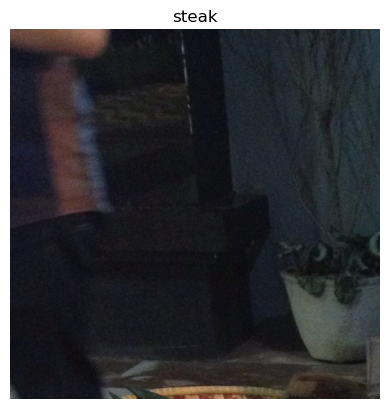

In [7]:
img = view_random_image(target_dir=cleanPath,
                        target_class="steak")

In [8]:
img

array([[[115,  82,  75],
        [118,  85,  78],
        [117,  84,  75],
        ...,
        [ 41,  57,  72],
        [ 42,  59,  75],
        [ 45,  62,  78]],

       [[105,  72,  65],
        [110,  77,  70],
        [113,  80,  71],
        ...,
        [ 42,  58,  73],
        [ 39,  56,  72],
        [ 40,  57,  73]],

       [[106,  73,  66],
        [112,  79,  72],
        [114,  81,  74],
        ...,
        [ 42,  58,  73],
        [ 40,  58,  72],
        [ 40,  58,  72]],

       ...,

       [[ 95, 105, 107],
        [ 91, 101, 103],
        [ 89,  99, 101],
        ...,
        [ 44,  40,  37],
        [ 43,  39,  36],
        [ 45,  41,  38]],

       [[ 95, 105, 107],
        [ 88,  98, 100],
        [ 85,  95,  97],
        ...,
        [ 42,  38,  35],
        [ 44,  40,  37],
        [ 49,  45,  42]],

       [[ 90, 100, 102],
        [ 83,  93,  95],
        [ 79,  89,  91],
        ...,
        [ 41,  37,  34],
        [ 42,  38,  35],
        [ 48,  44,  41]]

In [9]:
print(f'img shape: {img.shape}')

img shape: (512, 512, 3)


### Key Points
- the data is a bunch of images
- the images are split into directories: test & train, then by classification (2 classifications)
- the shape of the images are 512x512 with a 3-color representation per pixel (probably rgb)
  - it has become common to reshape the images to fit a `224x224` size
  - the rgb values
    - fit between 0-255, where 0 is "black" and 255 is "white"
    - 1st digit is `red`
    - 2nd digit is `green`
    - 3rd digit is `blue`

## Build A Model: CNN
### About Convolutional Neural Networks

Parts of a CNN:
- input (images)
- LAYERS & related details
  - **input layer**: batch_size, img dimensions, classification mode
  - **convolution layer**: figures out "the most important" patterns to learn, `Conv2D`
  - **hidden activation**: add "non-linearity" to learned features, most typically `relu`
  - **pooling layer**: reduces diemsions of learned features, `AvgPool2d`, `MaxPool2D`
  - **"fully connected" layer**: , a "last step" aggregating / refining the convolution layers `Dense`
  - **output layer**: fits to the desired number of "classes" to learn
  - **output activation** add non-linearity to the output layer, `sigmoid` or `softmax`

A typical CNN structure:
```Input -> Conv + ReLU layers (non-linearities) -> Pooling layer -> Fully connected (dense layer) as Output```

### Prep the model Data
- get data into "training" and "testing" datasets
- "batch" the data: sub-sets of data to minimize the data loaded into memory (GPU or CPU) at once
- scale the image data-values to be between 0-to-1

In [10]:
# Set the seed
tf.random.set_seed(42)
imgW = 224
imgH = 224
maxScaleNumber = 255

# 
# batch_size: limits amount of data in memory at once (in batches!)
# 32 has become a regular starting place in the machine-learning world
# 
imagesInABatch = 32

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
# rescaling normalizes 0-255 values to 0-1
# ImageDataGenerator DOCS (a lot there)
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./maxScaleNumber)
valid_datagen = ImageDataGenerator(rescale=1./maxScaleNumber)

# Setup the train and test directories
train_dir = "pizza_steak/train/"
test_dir = "pizza_steak/test/"

# 
# BATCH the data
# 
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=imagesInABatch, # number of images to process at a time 
                                               target_size=(imgW, imgH), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=imagesInABatch,
                                               target_size=(imgW, imgH),
                                               class_mode="binary",
                                               seed=42)
# for later modeling
test_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=imagesInABatch,
                                               target_size=(imgW, imgH),
                                               class_mode="binary",
                                               seed=42)

Found 1500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.


In [11]:
print(f'how many items in train_data? {len(train_data)}')
print(f'how many items in the firt element of train_data? {len(train_data[0])}')

how many items in train_data? 47
how many items in the firt element of train_data? 2


### Inspect some training data

In [12]:
# Get a sample of the training data batch 
images, labels = train_data.next() # get the 'next' batch of images/labels
print(f'images:{len(images)}, labels:{len(labels)}')

# NOTICE LABELS:
# 0 or 1
print('labels:')
labels

images:32, labels:32
labels:


array([0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
      dtype=float32)

### Build the Model

In [13]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
imageW = 224
imageH = 224
imageColorCount = 3
convoFilterCount = 10
convoKernelCount = 3
maxPoolSize = 2

m1 = tf.keras.models.Sequential([
  Conv2D(filters=convoFilterCount, 
                         kernel_size=convoKernelCount, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(imageW, imageH, imageColorCount)), # first layer specifies input shape (height, width, colour channels)
  Conv2D(convoFilterCount, convoKernelCount, activation="relu"),
  MaxPool2D(pool_size=maxPoolSize, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  Conv2D(convoFilterCount, convoKernelCount, activation="relu"),
  Conv2D(convoFilterCount, convoKernelCount, activation="relu"), # activation='relu' == Activations(tf.nn.relu)
  MaxPool2D(maxPoolSize),
  Flatten(),
  Dense(1, activation="sigmoid") # binary activation output
])

# Compile the model
m1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
m1History = m1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 259s 5s/step - loss: 0.6137 - accuracy: 0.6607 - val_loss: 0.4632 - val_accuracy: 0.7880
Epoch 2/5
47/47 [==============================] - 242s 5s/step - loss: 0.4803 - accuracy: 0.7707 - val_loss: 0.4165 - val_accuracy: 0.8180
Epoch 3/5
47/47 [==============================] - 242s 5s/step - loss: 0.4407 - accuracy: 0.8133 - val_loss: 0.3898 - val_accuracy: 0.8500
Epoch 4/5
47/47 [==============================] - 242s 5s/step - loss: 0.3904 - accuracy: 0.8393 - val_loss: 0.3481 - val_accuracy: 0.8580
Epoch 5/5
47/47 [==============================] - 241s 5s/step - loss: 0.3140 - accuracy: 0.8733 - val_loss: 0.3499 - val_accuracy: 0.8540


## Inspect The Model Results

In [14]:
# Check out model_3 architecture
m1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Build A Model II: Binary Classification
Binary classification models are significantly "simpler" than CNNs.  
Let's see how a Binary CLassification model 

### Modeling steps
- Familiarize with the data (visualize, visualize, visualize...)
- "Preprocess" the data (prepare it for a model)
- Create a model (start with a baseline)
  - Fit the model
- Evaluate the model
  - Adjust different parameters and improve model (try to beat your baseline)
- Repeat Evaluate & Adjust until satisfied

In [15]:
tf.random.set_seed(42)

# Create a model to replicate the TensorFlow Playground model
m2 = tf.keras.Sequential([
  Flatten(input_shape=(imgW, imgH, 3)), # dense layers expect a 1-dimensional vector as input
  Dense(4, activation='relu'),
  Dense(4, activation='relu'),
  Dense(1, activation='sigmoid')
])

# Compile the model
m2.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
m2History = m2.fit(train_data, # use same training data created above
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data, # use same validation data created above
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 20s 369ms/step - loss: 0.9434 - accuracy: 0.4893 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/5
47/47 [==============================] - 16s 350ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 17s 357ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/5
47/47 [==============================] - 17s 351ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/5
47/47 [==============================] - 16s 349ms/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000


### Inspect the Model

In [16]:
m1.summary()
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 10)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 53, 53, 10)        0         
 g2D)                                                   

## Build A Model III: Binary Adjusted

In [17]:
# Set random seed
tf.random.set_seed(42)

# Create a model similar to model_1 but add an extra layer and increase the number of hidden units in each layer
m3 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(imgW, imgH, 3)), # dense layers expect a 1-dimensional vector as input
  tf.keras.layers.Dense(100, activation='relu'), # increase number of neurons from 4 to 100 (for each layer)
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(100, activation='relu'), # add an extra layer
  tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
m3.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
m3History = m3.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/5
47/47 [==============================] - 59s 1s/step - loss: 4.3189 - accuracy: 0.6033 - val_loss: 1.2869 - val_accuracy: 0.6940
Epoch 2/5
47/47 [==============================] - 56s 1s/step - loss: 0.8009 - accuracy: 0.7120 - val_loss: 0.8136 - val_accuracy: 0.6260
Epoch 3/5
47/47 [==============================] - 56s 1s/step - loss: 1.0083 - accuracy: 0.6787 - val_loss: 0.4765 - val_accuracy: 0.7580
Epoch 4/5
47/47 [==============================] - 55s 1s/step - loss: 0.5737 - accuracy: 0.7447 - val_loss: 2.3730 - val_accuracy: 0.5220
Epoch 5/5
47/47 [==============================] - 55s 1s/step - loss: 0.6828 - accuracy: 0.7333 - val_loss: 1.2816 - val_accuracy: 0.5580


### Inspect The Model

In [18]:
m2.summary()
m3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 150528)            0         
                                                                 
 dense_1 (Dense)             (None, 4)                 602116    
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 602141 (2.30 MB)
Trainable params: 602141 (2.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #

Interestingly
- the binary classification models have WAY MORE PARAMETERS than the CNN

## Build A Model: CNN "Baseline"
Setup a "simple" model to start with:
- `2D` layers refer to the data have 2 "dimensions": height + width (color is a data attribute of each height/width pixel)
- `filters`: the number of "feature extractions", or "filters", that get "passed over" input tensors (10,32,64,128). The higher the number, the more complex the model.
- `kernel_size` is describes the shape of a grid of pixels of the filter. The smaller, the more "fine-grained" the feature detection / filter will be
- [`stride`](https://deepai.org/machine-learning-glossary-and-terms/stride): describes the movement of a kernel across the image (in pixels-per-stride)
- `padding`: to cut-off or not pixels when the `filter` may not cover pixels. a 224w image with a 3x3 filter will leave a few pixels un"filtered", as a 3px-wide filter will cover 222 pixels by moving 74x
- `features` in cnn are "significant" parts of images that the CNN has figured out

### Build

In [19]:
m4 = Sequential([
  Conv2D(filters=10, 
         kernel_size=3, 
         strides=1,
         padding='valid',
         activation='relu', 
         input_shape=(224, 224, 3)), # input layer (specify input shape)
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  Flatten(),
  Dense(1, activation='sigmoid') # output layer (specify output shape)
])

### Compile

In [20]:
# Compile the model
m4.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

In [21]:
# Fit the model
m4History = m4.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 304s 6s/step - loss: 3.1612 - accuracy: 0.5700 - val_loss: 0.5637 - val_accuracy: 0.6740
Epoch 2/5
47/47 [==============================] - 313s 7s/step - loss: 0.5346 - accuracy: 0.7207 - val_loss: 0.5108 - val_accuracy: 0.7260
Epoch 3/5
47/47 [==============================] - 292s 6s/step - loss: 0.4237 - accuracy: 0.8140 - val_loss: 0.4998 - val_accuracy: 0.7740
Epoch 4/5
47/47 [==============================] - 311s 7s/step - loss: 0.2787 - accuracy: 0.8960 - val_loss: 0.5315 - val_accuracy: 0.7560
Epoch 5/5
47/47 [==============================] - 309s 7s/step - loss: 0.1256 - accuracy: 0.9587 - val_loss: 0.6080 - val_accuracy: 0.7600


### Inspect & Compare

In [33]:
# m2.summary()
# m3.summary()
m4.summary() 

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 conv2d_5 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 conv2d_6 (Conv2D)           (None, 218, 218, 10)      910       
                                                                 
 flatten_3 (Flatten)         (None, 475240)            0         
                                                                 
 dense_8 (Dense)             (None, 1)                 475241    
                                                                 
Total params: 477341 (1.82 MB)
Trainable params: 477341 (1.82 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Evaluate
Visualze CNN Model Stats

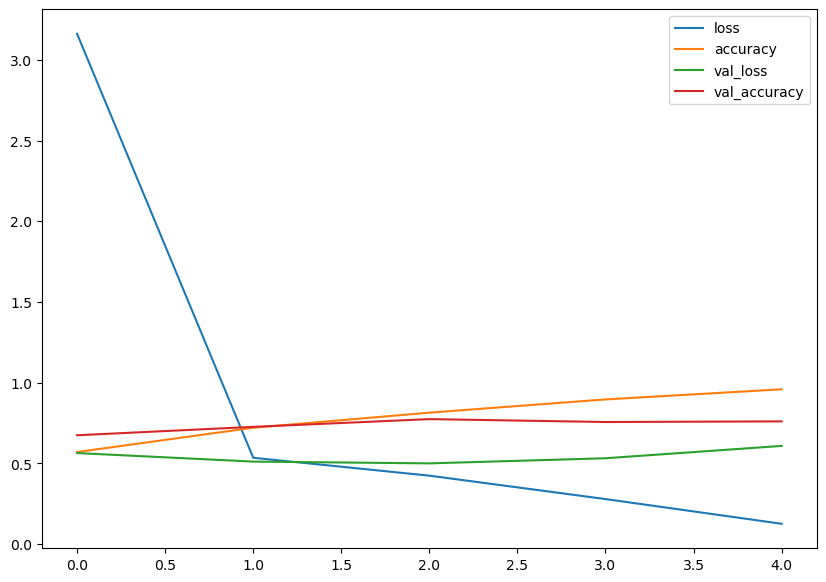

In [23]:
pd.DataFrame(m4History.history).plot(figsize=(10, 7));

In [24]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

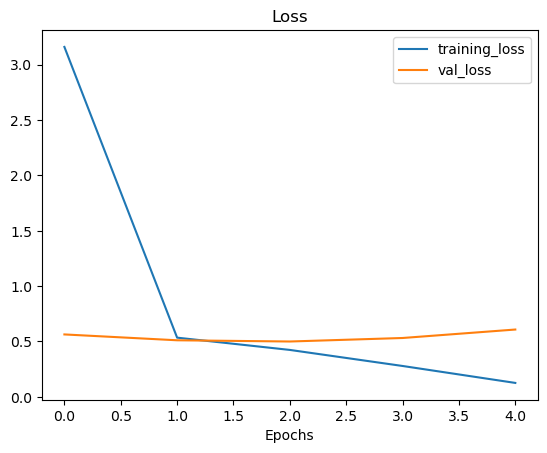

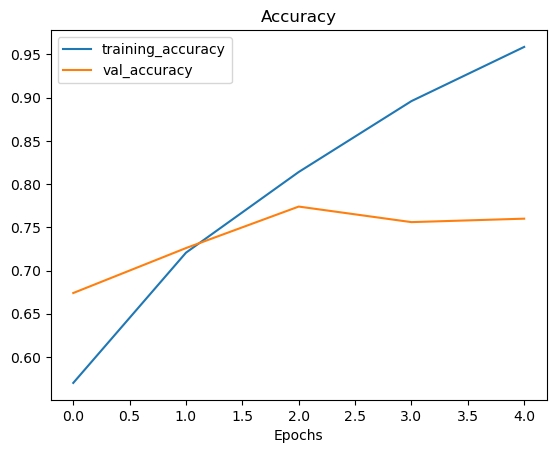

In [25]:
# Check out the loss curves of model_4
plot_loss_curves(m4History)

### Beware Overfitting
Above, the `val_loss` goes UP after the 3rd epoch. INCREASING loss means over-fitting. Over-fitting is when the model gets excellent at predicting based on the data it was trained & tested with, BUT will loose the ability to predict NEW input as well.  

Overfitting happens when...
- a "large" number of convolutional layers is present
- a "large" number of convolutional filters is present
- the "shape" of the accuracy curve-over-epochs has changed from going up to flat &/or going down
- the "shape" of the loss curve-over-epochs has "flattened out" from going down

## Adjust The Model
- build
- overfit
- **reduce overfitting** (by a few approaches):
  - adjust (reduce) number of convolutional layers
  - adjust number of convolutional filters
  - add dense layer to the output of the flattened layer
 
Here, we'll add a `MaxPool2D` layer after each `convolutional` layer.
### Build

In [26]:
m5 = Sequential([
  # convo-then-maxPool
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half
  # convo-then-maxPool
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  # convo-then-maxPool
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

### Compile

In [27]:
m5.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

### Fit

In [28]:
# Fit the model
m5History = m5.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 96s 2s/step - loss: 0.6475 - accuracy: 0.6487 - val_loss: 0.4795 - val_accuracy: 0.7980
Epoch 2/5
47/47 [==============================] - 92s 2s/step - loss: 0.4838 - accuracy: 0.7800 - val_loss: 0.3946 - val_accuracy: 0.8260
Epoch 3/5
47/47 [==============================] - 92s 2s/step - loss: 0.4420 - accuracy: 0.8087 - val_loss: 0.3836 - val_accuracy: 0.8400
Epoch 4/5
47/47 [==============================] - 92s 2s/step - loss: 0.4308 - accuracy: 0.8167 - val_loss: 0.3643 - val_accuracy: 0.8640
Epoch 5/5
47/47 [==============================] - 91s 2s/step - loss: 0.4014 - accuracy: 0.8307 - val_loss: 0.3595 - val_accuracy: 0.8520


### Evaluate
#### Plot The Loss & Accuracy Curves
See the "loss" as epochs increase. Expecting loss to go down while epochs go on. **When the validation loss starts to increase**, the model is probably over-fitting.
See the "accuracy" as epochs increase. Expecting accuracy to increase as epochs go on.  

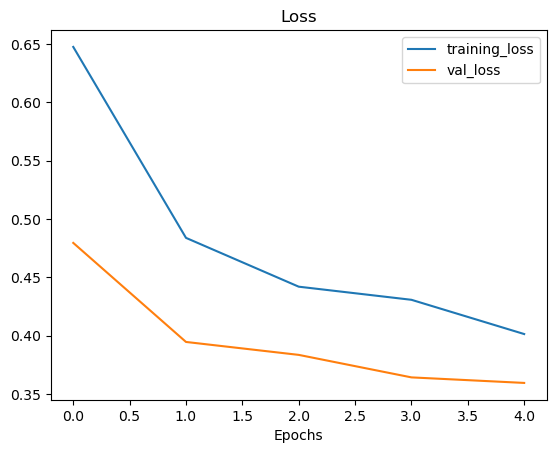

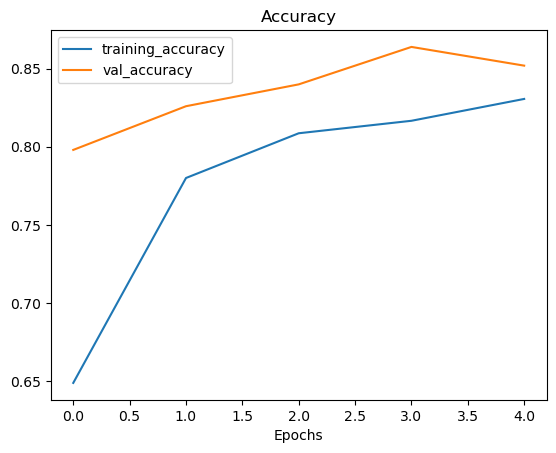

In [32]:
plot_loss_curves(m5History)

#### View Model Stats

In [35]:
m5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 222, 222, 10)      280       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 111, 111, 10)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 109, 109, 10)      910       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 54, 54, 10)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 52, 52, 10)        910       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 10)       

## Build A Model: Data Augmentation
### Data Augmentation
[tf docs on data augmentation!](https://www.tensorflow.org/tutorials/images/data_augmentation)  

- alter training data
- give training data more "diversity", helping "generalize" patterns for the model to learn
- i.e rotating, flipping, cropping, etc
- help prevent over-fitting: force the model to "learn" from "imperfect" &/or "augmented" images, mimicing real-world "new" images that the model has not-yet seen
- **NOTE**: testing will be done on (regular) non-augmented images
 
### Prep Data

In [44]:
# Create ImageDataGenerator training instance with data augmentation
train_datagen_augmented = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, 
                                             zoom_range=0.2, 
                                             width_shift_range=0.2, 
                                             height_shift_range=0.2, 
                                             horizontal_flip=True)

# 
# will re-use "train_datagen" from above
# 
# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1/255.)
print("Augmented training images")
train_data_augmented = train_datagen_augmented.flow_from_directory(train_dir,
                                                                   target_size=(224, 224),
                                                                   batch_size=32,
                                                                   class_mode='binary',
                                                                   shuffle=False)

print("Non-augmented training images:")
augmented_train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode='binary',
                                               shuffle=False) # Don't shuffle for demonstration purposes

print("Unchanged test images:")
augmented_test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode='binary')

Augmented training images
Found 1500 images belonging to 2 classes.
Non-augmented training images:
Found 1500 images belonging to 2 classes.
Unchanged test images:
Found 500 images belonging to 2 classes.


### Preview Some "augmented" Images

In [45]:
# get data to preview
images, labels = augmented_train_data.next()
augmented_images, augmented_labels = train_data_augmented.next() # Note: labels aren't augmented, they stay the same

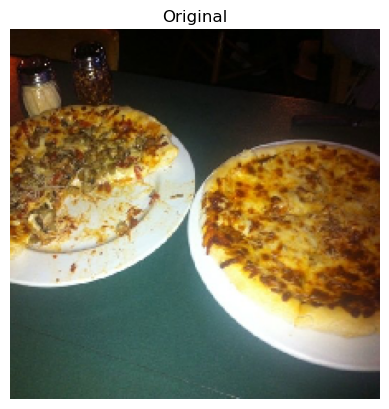

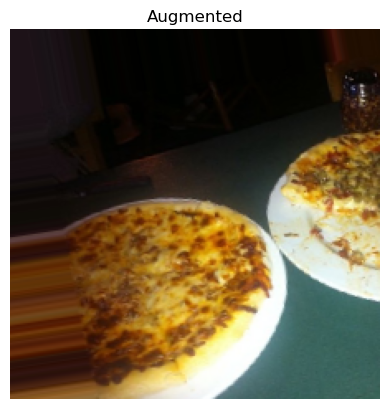

In [55]:
random_number = random.randint(0, 31) # we're making batches of size 32, so we'll get a random instance

# 
# Show original image and augmented image
# 
plt.imshow(images[random_number])
plt.title(f"Original")
plt.axis(False)
plt.figure()
plt.imshow(augmented_images[random_number])
plt.title(f"Augmented")
plt.axis(False);

### Build The Model

In [56]:
# 
# mostly the SAME as m5, BUT using the augmented training data
# 
m6 = Sequential([
  # conv-then-max-pool
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(pool_size=2), # reduce number of features by half

  # conv-then-max-pool
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),

  # conv-then-max-pool
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
m6.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
# NOTE: TESTING on non-augmented data
m6History = m6.fit(train_data_augmented, # changed to augmented training data
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 106s 2s/step - loss: 0.7066 - accuracy: 0.4747 - val_loss: 0.6766 - val_accuracy: 0.5980
Epoch 2/5
47/47 [==============================] - 100s 2s/step - loss: 0.6965 - accuracy: 0.5440 - val_loss: 0.6847 - val_accuracy: 0.5000
Epoch 3/5
47/47 [==============================] - 101s 2s/step - loss: 0.6907 - accuracy: 0.5327 - val_loss: 0.6581 - val_accuracy: 0.5560
Epoch 4/5
47/47 [==============================] - 101s 2s/step - loss: 0.6807 - accuracy: 0.5713 - val_loss: 0.5611 - val_accuracy: 0.6800
Epoch 5/5
47/47 [==============================] - 100s 2s/step - loss: 0.6748 - accuracy: 0.6207 - val_loss: 0.5673 - val_accuracy: 0.7840


### Inspect Model
- the accuracy of `m6`, `.62...`, is lower than `m5`

### visualise loss & accuracy

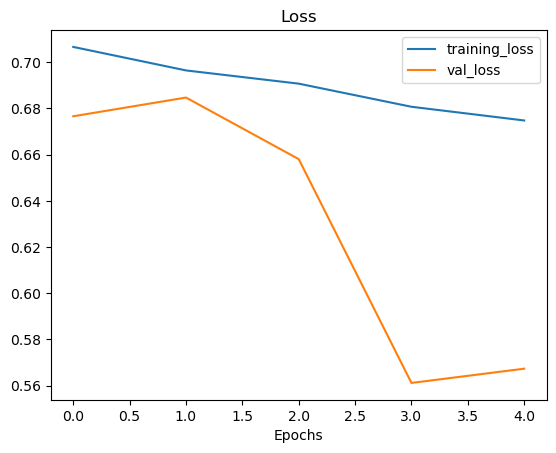

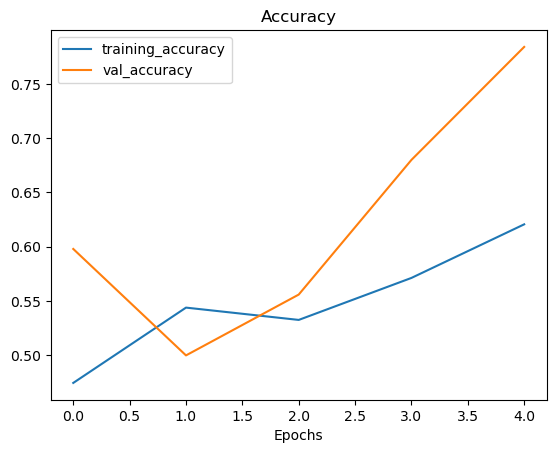

In [57]:
plot_loss_curves(m6History)

## Build A Model: Augmented AND shuffled
Shuffling the training data can be one way to reduce any learning influenced by the order of the training data. 
### Build & Compile

In [60]:
# 
# This is ALMOST identical to the above augmentation
# BUT shuffle is set to TRUE
# 
train_data_augmented_shuffled = train_datagen_augmented.flow_from_directory(train_dir,
                                                                            target_size=(224, 224),
                                                                            batch_size=32,
                                                                            class_mode='binary',
                                                                            shuffle=True) # Shuffle data (default)

Found 1500 images belonging to 2 classes.


In [59]:
# Create the model (same as model_5 and model_6)
m7 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
m7.compile(loss='binary_crossentropy',
                optimizer=Adam(),
                metrics=['accuracy'])

# Fit the model
m7History = m7.fit(train_data_augmented_shuffled, # now the augmented data is shuffled
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 106s 2s/step - loss: 0.6616 - accuracy: 0.5980 - val_loss: 0.5198 - val_accuracy: 0.7880
Epoch 2/5
47/47 [==============================] - 101s 2s/step - loss: 0.5803 - accuracy: 0.6900 - val_loss: 0.4904 - val_accuracy: 0.7360
Epoch 3/5
47/47 [==============================] - 100s 2s/step - loss: 0.5315 - accuracy: 0.7507 - val_loss: 0.4178 - val_accuracy: 0.8280
Epoch 4/5
47/47 [==============================] - 101s 2s/step - loss: 0.5012 - accuracy: 0.7787 - val_loss: 0.4188 - val_accuracy: 0.8220
Epoch 5/5
47/47 [==============================] - 100s 2s/step - loss: 0.4951 - accuracy: 0.7687 - val_loss: 0.3648 - val_accuracy: 0.8520


### Inspect Model
- the accuracy of `m7`, `.76...`, compared to the "baseline" m4 at `.95` . the baseline continues to be the best. very interesting.
### visualise loss & accuracy

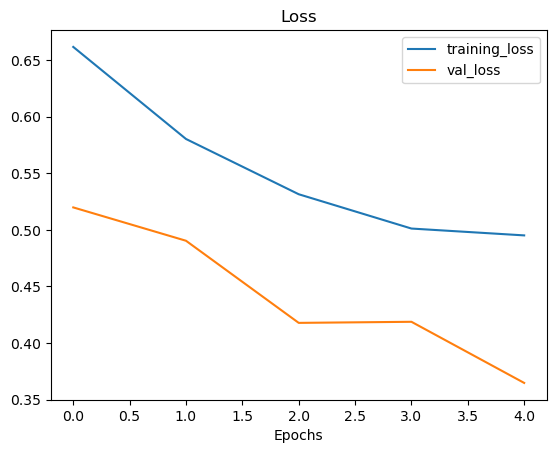

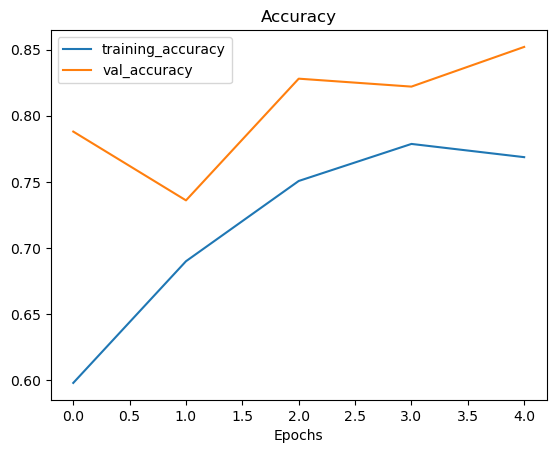

In [61]:
plot_loss_curves(m7History)

The shapes of the loss-curve & accuracy curve look better than the previous model.  

## Build A Model: Tiny VGG Influence
One way to go about this is to find already-existing model architectures. Models have already been developed for these types of goals, and their model architectures may be available to find online.  
The [CNN Explainer Website](https://poloclub.github.io/cnn-explainer/) uses a [Tiny VGG](https://cs231n.stanford.edu/) architecture (some code based on the architecture [here](https://github.com/poloclub/cnn-explainer/blob/master/tiny-vgg/tiny-vgg.py)). Here, a model based on that architecture, including `augmented` and `shuffled` training data.

### Build

In [68]:
# Create a CNN model (same as Tiny VGG but for binary classification - https://poloclub.github.io/cnn-explainer/ )
m8 = Sequential([
  Conv2D(10, 3, activation='relu', input_shape=(224, 224, 3)), # same input shape as our images
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Conv2D(10, 3, activation='relu'),
  Conv2D(10, 3, activation='relu'),
  MaxPool2D(),
  Flatten(),
  Dense(1, activation='sigmoid')
])

# Compile the model
m8.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
m8History = m8.fit(train_data_augmented_shuffled,
                        epochs=5,
                        steps_per_epoch=len(train_data_augmented_shuffled),
                        validation_data=test_data,
                        validation_steps=len(test_data))

Epoch 1/5
47/47 [==============================] - 249s 5s/step - loss: 0.6798 - accuracy: 0.5927 - val_loss: 0.5110 - val_accuracy: 0.7600
Epoch 2/5
47/47 [==============================] - 244s 5s/step - loss: 0.5381 - accuracy: 0.7353 - val_loss: 0.4637 - val_accuracy: 0.7540
Epoch 3/5
47/47 [==============================] - 243s 5s/step - loss: 0.5397 - accuracy: 0.7300 - val_loss: 0.3879 - val_accuracy: 0.8540
Epoch 4/5
47/47 [==============================] - 244s 5s/step - loss: 0.5143 - accuracy: 0.7533 - val_loss: 0.3791 - val_accuracy: 0.8480
Epoch 5/5
47/47 [==============================] - 244s 5s/step - loss: 0.4838 - accuracy: 0.7780 - val_loss: 0.3801 - val_accuracy: 0.8660


### Inspect
- the accuracy of `m8`, `.77...`, compared to the "baseline" m4 at `.95` . the baseline continues to be the best. very interesting.
### visualise loss & accuracy

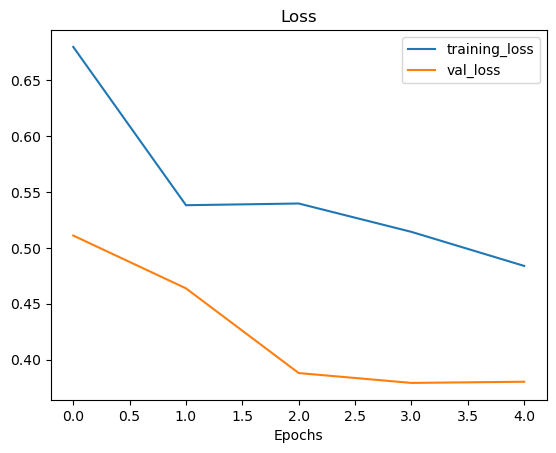

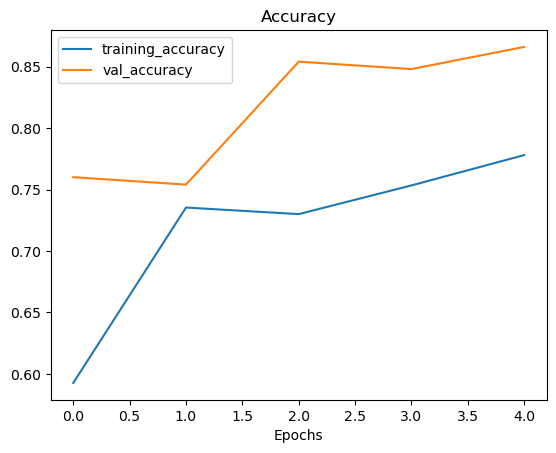

In [71]:
plot_loss_curves(m8History)

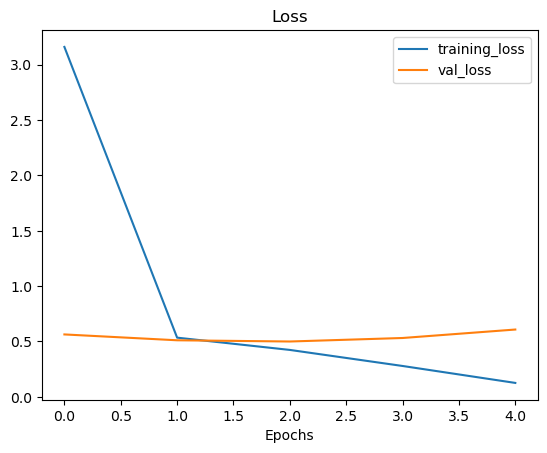

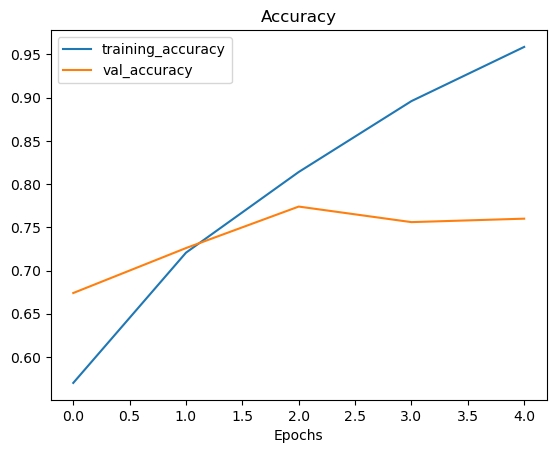

In [74]:
plot_loss_curves(m4History)

In [73]:
m8History.history['loss']

[0.6797893643379211,
 0.5381284952163696,
 0.5396506786346436,
 0.5142636895179749,
 0.48379725217819214]

## Predicting Images with the best model
### Get An Image

--2024-06-19 14:20:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1978213 (1.9M) [image/jpeg]
Saving to: ‘03-steak.jpeg.1’

03-steak.jpeg.1     100%[===================>]   1.89M  7.88MB/s    in 0.2s    

2024-06-19 14:20:16 (7.88 MB/s) - ‘03-steak.jpeg.1’ saved [1978213/1978213]



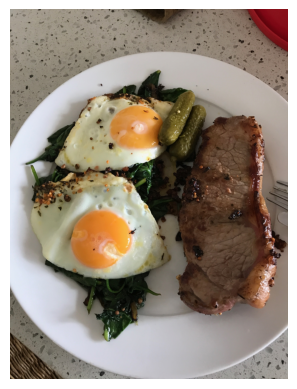

In [63]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-steak.jpeg 
steak_to_predict = mpimg.imread("03-steak.jpeg")
plt.imshow(steak_to_predict)
plt.axis(False);

In [65]:
steak_to_predict.shape

(4032, 3024, 3)

### Prepare Image For the Model
Here, a function to help prep images:
- read an image from the file-system
- convert the image to a tensor, including the expected number of color channels (3)
- resize the img
- scale the image tensor values

In [66]:
# import, translate to tensor, resize & rescale
def load_and_prep_image(filename, img_shape=224):
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [67]:
# Load in and preprocess our custom image
preppedSteakImg = load_and_prep_image("03-steak.jpeg")
preppedSteakImg

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.6377451 , 0.6220588 , 0.57892156],
        [0.6504902 , 0.63186276, 0.5897059 ],
        [0.63186276, 0.60833335, 0.5612745 ],
        ...,
        [0.52156866, 0.05098039, 0.09019608],
        [0.49509802, 0.04215686, 0.07058824],
        [0.52843136, 0.07745098, 0.10490196]],

       [[0.6617647 , 0.6460784 , 0.6107843 ],
        [0.6387255 , 0.6230392 , 0.57598037],
        [0.65588236, 0.63235295, 0.5852941 ],
        ...,
        [0.5352941 , 0.06862745, 0.09215686],
        [0.529902  , 0.05931373, 0.09460784],
        [0.5142157 , 0.05539216, 0.08676471]],

       [[0.6519608 , 0.6362745 , 0.5892157 ],
        [0.6392157 , 0.6137255 , 0.56764704],
        [0.65637255, 0.6269608 , 0.5828431 ],
        ...,
        [0.53137255, 0.06470589, 0.08039216],
        [0.527451  , 0.06862745, 0.1       ],
        [0.52254903, 0.05196078, 0.0872549 ]],

       ...,

       [[0.49313724, 0.42745098, 0.31029412],
        [0.05

In [90]:
# 
# function to convert a predicted value, between 0-1, to the classification 
# AND plot the image on a visual & show the prediction
# 
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  pred_class = class_names[int(tf.round(pred)[0][0])]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

### Predict

In [77]:
m8.predict(preppedSteakImg, axis=0)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_212/2808857747.py", line 1, in <module>
    m8.predict(preppedSteakImg, axis=0)
  File "/opt/conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/opt/conda/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: Model.predict() got an unexpected keyword argument 'axis'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.Interact

The prediction error here is due to a shape mismatch between the image being predicted and the TRAINED image shapes.  

In [78]:
preppedSteakImg.shape

TensorShape([224, 224, 3])

In [82]:
train_data_augmented_shuffled[0][0].shape

(32, 224, 224, 3)

the trained image shape is `(32, 224, 224, 3)` and the predicted image shape is `224, 224, 3`.  
The difference, there, is that the first number in the trained images is `32`, which just-so-happens (not a coincidence) to be the batch number.  
In order to get the predicted image shape to match the trained image shape, the `expand_dims` function can be used:

In [88]:
shapedPredictionImage = tf.expand_dims(preppedSteakImg, axis=0)
shapedPredictionImage.shape

TensorShape([1, 224, 224, 3])

### Predict Again

In [89]:
m8.predict(shapedPredictionImage)

1/1 [==============================] - 0s 87ms/step


array([[0.66845244]], dtype=float32)

1/1 [==============================] - 0s 104ms/step


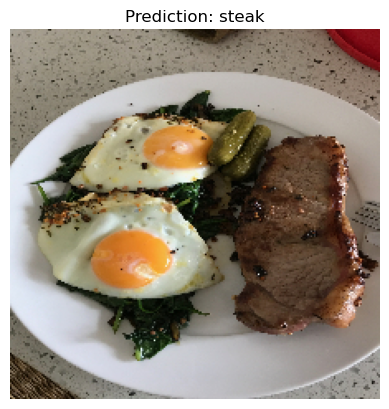

In [92]:
# def pred_and_plot(model, filename, class_names)
pred_and_plot(m8, '03-steak.jpeg', npClassNames)

--2024-06-19 17:21:04--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2874848 (2.7M) [image/jpeg]
Saving to: ‘03-pizza-dad.jpeg.1’

03-pizza-dad.jpeg.1 100%[===================>]   2.74M  9.69MB/s    in 0.3s    

2024-06-19 17:21:04 (9.69 MB/s) - ‘03-pizza-dad.jpeg.1’ saved [2874848/2874848]

1/1 [==============================] - 0s 89ms/step


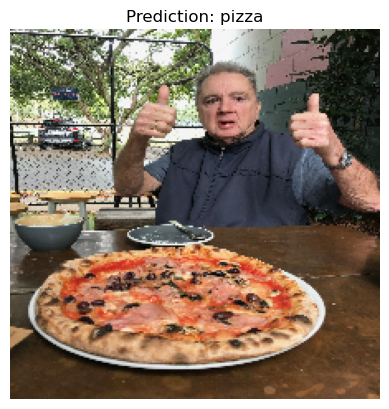

In [94]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/images/03-pizza-dad.jpeg 
pred_and_plot(m8, "03-pizza-dad.jpeg", npClassNames)